<a href="https://colab.research.google.com/github/Hayesdb1742/Structured_Light_Camera/blob/main/Copy_of_lab06_nlls_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab:  Nonlinear Least-Squares

In this lab, we will explore gradient descent for nonlinear least squares.  Our goal is to fit a nonlinear model of the form

     yhat ~= f(x,w)
     
where `x` is a vector of features, `w` is a vector of parameters and `f` is a nonlinear function of `w`.
To do this, we will seach for the parameters `w` that minimize the RSS cost

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
summed over training samples `(x_i,y_i)`.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to a dataset from the National Institute of Standards.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving scanning electron microscope line width standards.

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Kirby2.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df

,y0,x0,dummy
0,0.0082,9.65,NaN
1,0.0112,10.74,NaN
2,0.0149,11.81,NaN
3,0.0198,12.88,NaN
4,0.0248,14.06,NaN
...,...,...,...
146,90.5500,360.20,NaN
147,90.9300,362.67,NaN
148,91.2000,364.53,NaN
149,91.5500,367.00,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`.

Text(0.5, 1.0, 'x vs y')

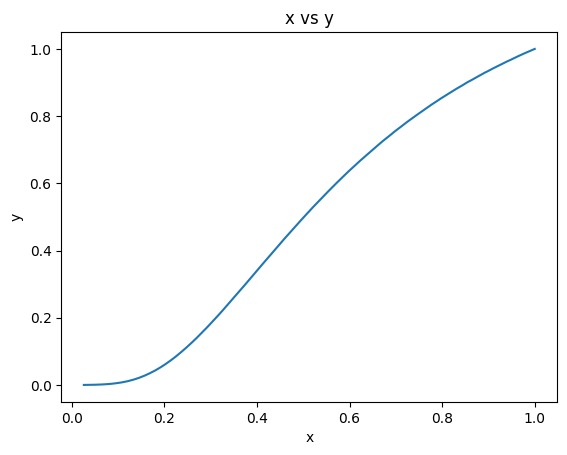

In [3]:
# TODO
x0 = df['x0']
y0 = df['y0']
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and standard deviation = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

Text(0.5, 1.0, 'yn vs x')

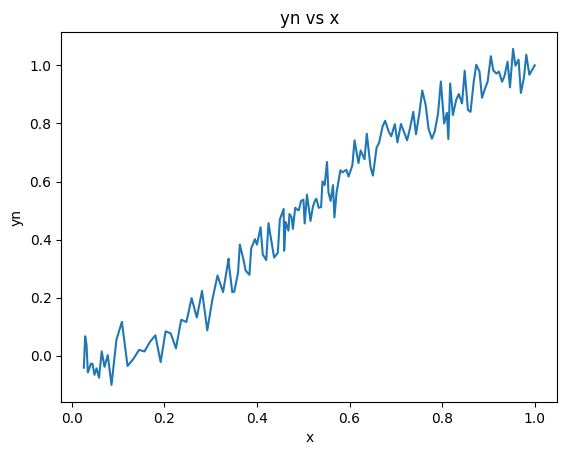

In [4]:
# TODO
yn = y + np.random.normal(0,0.05,len(y))
plt.plot(x,yn)
plt.xlabel('x')
plt.ylabel('yn')
plt.title('yn vs x')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## A Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (b[0] + b[1]*x + ... + b[d]*x^d)/(1 + a[0]*x + ... + a[m-1]*x^m)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[m-1],b[0],...,b[d]]`, so there are `d+m+1` parameters total.
Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x,m):

    # TODO.  Extract a,b from w,m
    a = w[0:m]
    b = w[m:]

    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order of a and b because np.polyval(c,x) outputs
    #  c[0]*x**(d) + c[1]*x**(d-1) + ... + c[d-1]*x + c[d]

    arev = a[::-1]
    brev = b[::-1]
    yhat = np.divide(np.polyval(brev,x),(1+x*(np.polyval(arev,x))))

    return yhat

Every time you write a block of code, you should test/debug it before moving on.
We can test our `predict` function by creating simple instances of `w`, `x`, `m`, `d` for which `yhat` is easily computed by hand.
To do this, set `d=2=m` and `x=2` and run it at least once with `w` in `{[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1],[1,0,1,0,0],[0,1,1,0,0]}` to be absolutely sure that your `predict` function is working as expected.
Don't move on until this step is complete.

In [7]:
# TODO.  Write a simple piece of debugging code
d = 2
m = 2
x = 2
w = np.array([0,1,1,0,0])
yhat = predict(w,x,m)
print(yhat)
## for w in {} above, yhat = {1.0,2.0,4.0,0.5,0.33333}

0.2


## Parameter Initialization

When we fit with a nonlinear model, most methods only obtain convergence to a *local* minimum, which is not necessarily good.  To converge to the *global* minimum, we need a good initialization.  For a rational model, one way to get a good initialization is to use the following trick.  First, realize that if

    y ~= (b[0] + b[1]*x + ... + b[d]*x^d)/(1 + a[0]*x + ... + a[m-1]*x^m)
    
then, by rearranging, we get

    y ~= - a[0]*y*x + ... - a[m-1]*y*x^m + b[0] + b[1]*x + ... + b[d]*x^d .
    
Note that this latter model is not useful for *prediction* of `y` from `x`. But it *is* useful for least-squares fitting the parameters `a` and `b` when you have a set of training samples of `x` and `y`.  

To do this least-squares fit, we can solve for parameter vector `w = [a,b]` using linear regression with the newly defined `i`th feature vector

    Z[i,:] = [ -y[i]*x[i]**1, ... , -y[i]*x[i]**m, x[i]**0, ... , x[i]**d ].
    
Make sure to use `fit_intercept = False` in `LinearRegression` because the `b[0]` term will act as the intercept.

As a hint, realize that a matrix with rows `[ x[i]**0, ... , x[i]**d]` can be efficiently created using broadcasting as `xtr[:,None]**jj[None,:]`, where `jj = [0,...,d]`.  For more on broadcasting, see the demo in Unit 0, especially the "outer product" section.  

In [8]:
# Set model order
d = 3
m = 2

# TODO.  Create the transformed feature matrix

kk = np.arange(1,m+1) # the vector [1,...,m]
Z1 =  -ytr[:,None]*xtr[:,None]**(kk[None,:])# so that Z1[i,k] = -y[i]*x[i]**(k+1)
jj = np.arange(0,d+1) # the vector [0,...,d]
Z2 = xtr[:,None]**jj[None,:]  # so that Z2[i,j] = x[i]**j
Z = np.hstack((Z1, Z2))


# # TODO.  Fit with parameters with linear regression
regr = LinearRegression(fit_intercept = False)
regr.fit(Z,ytr)

# Extract the parameters from regr.coef_ and store the parameter vector in winit
winit = regr.coef_


<ipython-input-8-ec35a3df64a7>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Z1 =  -ytr[:,None]*xtr[:,None]**(kk[None,:])# so that Z1[i,k] = -y[i]*x[i]**(k+1)
<ipython-input-8-ec35a3df64a7>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Z2 = xtr[:,None]**jj[None,:]  # so that Z2[i,j] = x[i]**j


Now using the `predict` function and your initial parameter estimate `winit`, compute `yhat` for 1000 values of `x` uniformly spaced over the interval `[0,1]`.  Plot `yhat` versus `x`.  You should see that the prediction curve has some singularities (i.e., places where it goes to infinity).  On the same plot, superimpose the points `(xts,yts)`.  Use the `axis` command to restrict your plot to the interval between -0.1 and 1.1 for both `x` and `y`.

Text(0, 0.5, 'y')

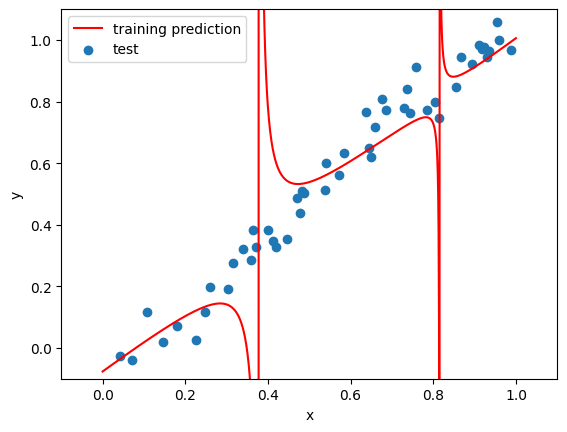

In [9]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp,m)
plt.plot(xp,yhat,c='r',label='training prediction')
plt.scatter(xts,yts,label='test')
plt.axis([-0.1,1.1,-0.1,1.1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To alleviate this problem, we can use Ridge regression instead of least-squares, in order to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 2e-1`. You should see a much better (but not perfect) fit.

Text(0, 0.5, 'y')

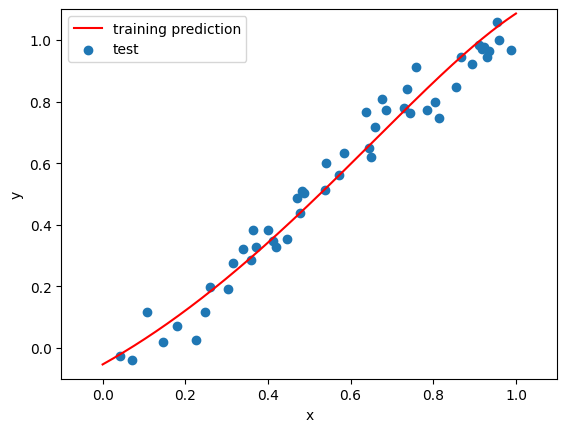

In [10]:
# TODO.  Fit with parameters with linear regression
regr = Ridge(alpha=2e-1,fit_intercept=False)
regr.fit(Z,ytr)

# TODO
#Extract the parameters from regr.coef_
winit = regr.coef_

# TODO
# Plot the results as above
yhat = predict(winit,xp,m)
plt.plot(xp,yhat,c='r',label='training prediction')
plt.scatter(xts,yts,label='test')
plt.axis([-0.1,1.1,-0.1,1.1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')


## Implementing loss and gradient using Numpy broadcasting

We can now use gradient descent to improve our initial estimate of the weights `w` computed using ridge regression.  Complete the construction of the following function, which is used to compute the (scaled) RSS cost

    J(w) = \sum_i (y[i] - yhat[i])^2
    
and `Jgrad`, the gradient of `J(w)`.  Your code should use Numpy broadcasting and matrix/vector multiplies as needed, and no "for" loops.  It should be written as efficiently as possible, so that no computations are repeated unnecessarily.

In [62]:
from re import X
def Jeval(w,x,y,m):

    # TODO.  Extract a,b,d from w,m
    a = w[0:m]
    b = w[m:]
    d = len(w)-m-1

    # TODO.  From vector x, use broadcasting to create matrix Xnum such that Xnum[i,j] = x[i]**j
    jj = np.arange(0,d+1)
    Xnum = x[:,None]**jj[None,:]

    # TODO.  From vector x, use broadcasting to create matrix Xden such that Xden[i,k] = x[i]**(k+1)
    kk = np.arange(1,m+1)
    Xden = x[:,None]**kk[None,:]

    # TODO.  Compute yhat using Xnum, Xden, a, and b
    # yhat = (b[0] + b[1]*x + ... + b[d]*x^d)/(1 + a[0]*x + ... + a[m-1]*x^m)
    Ynum = Xnum.dot(b)
    Yden = 1+Xden.dot(a)
    yhat = np.divide(Ynum,Yden)

    # TODO.  Compute loss J from vectors y and yhat

    e = yhat-y
    J = np.sum(e**2)

    # TODO.  Compute loss gradient dJ/dw
    print(Xnum.shape,Yden.shape)
    print(Ynum.shape,np.sum(Xnum).shape,(Yden**2).shape)

    Jgradb = -2*np.sum(e*np.divide(Xnum,Yden))
    Jgrada = 2*np.sum(e*np.divide(Ynum*Xden,Yden**2))

    Jgrad = np.hstack((Jgrada,Jgradb))

    return J,Jgrad

First, test the `yhat` steps in the code above by *temporarily* returning `yhat` and comparing it to the output of `predict`. I suggest using `w=winit`, a simple scalar `x` such as `x=np.array([2.])`, and an arbitrary `y` of the same length.  If it fails, you could try a simpler version of `w` to debug the problem.  Don't move on until this step is working.

In [31]:
#TODO
# w = winit
# x = np.array([2.])
# y = np.array([3.])
# m = 2
# yhat = Jeval(w,x,y,m)
# yhat2 = predict(w,x,m)


# print(yhat,yhat2) Works!


[-9.28545089] [-9.28545089]


Now that `yhat` is correctly computed, make sure `Jeval` returns only `J` and `Jgrad`, and comment out the test block above so that your notebook still runs without error.

Next, we will test the gradient computation in `Jeval`:
* Set `w0 = winit` and compute `J0,Jgrad0 = Jeval(w0,xtr,ytr)`
* Generate a random `w1` very close to `w0` and compute `J1,Jgrad1 = Jeval(w1,xtr,ytr)`
* Verify that `J1-J0` matches `Jgrad0.dot(w1-w0)` up to several digits of precision

Don't move on until this step is working.

In [63]:
# TODO
w0 = winit
w1 = w0 + np.random.normal(0,0.1,len(w0))
J0, Jgrad0 = Jeval(w0,xtr,ytr,m)
J1, Jgrad1 = Jeval(w1,xtr,ytr,m)
error = J1 - J0
jgradtest = Jgrad0.dot(w1-w0)

print(error,jgradtest)


(101, 4) (101,)
(101,) () (101,)


<ipython-input-62-a4d4b1093510>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xnum = x[:,None]**jj[None,:]
<ipython-input-62-a4d4b1093510>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Xden = x[:,None]**kk[None,:]


ValueError: ignored

## Implement gradient descent

We will now attempt to minimize the loss function using gradient descent.  Using the function `Jeval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-4` starting at `w=winit`.  Run it for `nit=100000` iterations.  Compute `Jgd[it]`, the cost attained by gradient descent at iteration `it`.  Plot `Jgd[it]` vs. `it` on a log-log scale.  

You should see that the training loss decreases but does not fully converge after 10000 iterations.

In [ ]:
# TODO
nit = 100000
step = 1e-4


Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `Jadapt[it]` be the loss value that it attains on iteration `it`.  Plot `Jadapt[it]` and `Jgd[it]` vs. `it` on the same log-log graph.  You should see some improvement, but also some lingering problems.

In [ ]:
# TODO
nit = 100000
step = 1e-3  # Initial step


Using the final estimate for `w` from the adaptive step-size approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`  computed using ridge regression.  Also, plot the test data, `yts` vs. `xts`.  You should see that gradient descent was able to improve the prediction model.

In [ ]:
#TODO


## Momentum Gradient Descent

This section is optional.

One way to improve gradient descent is to use *momentum*.  With momentum, the gradient-descent update rule becomes:

    J, Jgrad = Jeval(w,...)
    z = beta*z + Jgrad
    w = w - step*z
    
This is similar to gradient descent, except that the update direction `z` is the sum of the gradient `Jgrad` and the previous update direction `z`, which tends to keep the algorithm moving in the same direction (instead of randomly changing directions, as it would if `z=Jgrad`).  Implement momentum gradient-descent with `beta = 0.95` and `step=1e-3`.  Compare the convergence of this approach to plain gradient descent and the adaptive stepsize version.  

In [ ]:
# TODO
nit = 100000
step = 1e-3
beta = 0.95


Using the final estimate for `w` from the momentum approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the adaptive stepsize method.  Also, plot the test data, `yts` vs. `xts`.  

In [ ]:
# TODO
